# # Zillow Regression Project
Mack McGlenn, O'neil Cohort

### Project Overview
_____________________________________________________________________________________
This project will identify key drivers in determining tax value from the 2017 Zillow property dataset. Those drivers will then be taken to create a regression model which will best reduce rmse in predicting a home's tax value.

**Objectives**

- Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter notebook final report.

- Create modules (wrangle.py) that make your process repeateable and your report (notebook) easier to read and follow.

- Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

- Construct a model to predict assessed home value for single family properties using regression techniques.

- Make recommendations to a data science team about how to improve predictions.

**Business Goals**

- Construct an ML Regression model that predicts propery tax assessed values ('taxvaluedollarcnt') of Single Family Properties using attributes of the properties.

- Find the key drivers of property value for single family properties.

**Deliverables**

- a complete readme.md
- a final report (.ipynb)
- wrangle.py
- exploratory workbook
- data dictionary

## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import env
import zwrangle as wr

from scipy import stats
from scipy.stats import pearsonr, spearmanr

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression


from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

**Data Dictionary**

In [2]:
pd.read_csv('zillow_dd.csv', index_col=0)

,Description,Data Type
Features,,
tax_val,assessed tax value of a property. target variable,float
beds,number of bedrooms in a property. measured in ...,float
baths,number of bathrooms in a property. measured in...,float
sq_ft,size of a property in square feet,float
Los Angeles,returns dummy variable that identifies propert...,int
Orange County,returns dummy variable that identifies propert...,int
Ventura,returns dummy variable that identifies propert...,int
yard_sqft,lot size - size of property,float
county,identifies what county a property is in based ...,string


## 1. Acquire & Prepare

#### Acquire
- Data acquired from CodeUp Database using get_zillow() function 
-  1500000 rows × 9 columns
- metrics called: bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, fips, lotsizesquarefeet,taxvaluedollarcnt, yearbuilt, assessmentyear, taxamount

#### Prepare Actions:
- Drop null values from columns
- Rename columns for ease of delivery
- Feature engineered new metric called 'yard_sqft' 
- Reassign values in 'fips' column to new variable called 'county', which returns the names of the county where the homes are being evaluated
- Created dummy variables for 'county' column
- Remove outliers from dataset
- Split data into train/val/test datasets

#### Functions called from wrangle.py:
1. get_zillow()
2. prep_zillow(df)
3. remove_outliers(df, columns)
4. split_zillow(df)

In [3]:
# Importing my data from mySQL
df = wr.get_zillow()

In [4]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,taxvaluedollarcnt,yearbuilt,assessmentyear,taxamount
0,0.0,0.0,NaN,6037.0,4083.0,27516.0,NaN,2015.0,NaN
1,0.0,0.0,NaN,6037.0,11975.0,10.0,NaN,2016.0,NaN
2,0.0,0.0,NaN,6037.0,9403.0,10.0,NaN,2016.0,NaN
3,0.0,0.0,NaN,6037.0,3817.0,2108.0,NaN,2016.0,174.21
4,4.0,2.0,3633.0,6037.0,9826.0,296425.0,2005.0,2016.0,6941.39


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 9 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    1499994 non-null  float64
 1   bathroomcnt                   1499994 non-null  float64
 2   calculatedfinishedsquarefeet  1494108 non-null  float64
 3   fips                          1500000 non-null  float64
 4   lotsizesquarefeet             1490627 non-null  float64
 5   taxvaluedollarcnt             1499651 non-null  float64
 6   yearbuilt                     1493515 non-null  float64
 7   assessmentyear                1499999 non-null  float64
 8   taxamount                     1496901 non-null  float64
dtypes: float64(9)
memory usage: 103.0 MB


In [6]:
# Changing variable name in case I need to return to the original df
zillow = df

In [7]:
#Prepping df according to guidelines above
zillow = wr.prep_zillow(df)

In [8]:
zillow.head()

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft
4,4.0,2.0,3633.0,6037.0,9826.0,296425.0,2005.0,2016.0,6941.39,Los Angeles,1,0,0,6193.0
7,3.0,2.0,2077.0,6037.0,6490.0,646760.0,1926.0,2016.0,7924.68,Los Angeles,1,0,0,4413.0
11,0.0,0.0,1200.0,6037.0,4054.0,5328.0,1972.0,2016.0,91.60,Los Angeles,1,0,0,2854.0
14,0.0,0.0,171.0,6037.0,13002.0,6920.0,1973.0,2016.0,255.17,Los Angeles,1,0,0,12831.0
15,0.0,0.0,203.0,6037.0,17359.0,14166.0,1960.0,2016.0,163.79,Los Angeles,1,0,0,17156.0


In [9]:
# Taking a look before removing outliers
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
beds,1483530.0,3.300795,0.929669,0.00,3.0000,3.0,4.00,2.500000e+01
baths,1483530.0,2.236626,0.985999,0.00,2.0000,2.0,3.00,2.000000e+01
sq_ft,1483530.0,1860.439700,1239.380037,1.00,1258.0000,1622.0,2204.00,9.525760e+05
fips,1483530.0,6048.364934,20.415628,6037.00,6037.0000,6037.0,6059.00,6.111000e+03
lot_size,1483530.0,10937.035812,314426.497033,104.00,5637.0000,6760.0,8545.00,3.710005e+08
tax_val,1483530.0,458713.032262,667602.239161,22.00,188746.0000,327671.0,533120.75,9.018846e+07
year,1483530.0,1960.848509,22.026673,1801.00,1949.0000,1958.0,1975.00,2.016000e+03
assessmentyear,1483530.0,2015.999447,0.032938,2014.00,2016.0000,2016.0,2016.00,2.016000e+03
tax_amt,1483530.0,5589.462899,7696.330741,13.36,2536.4425,4104.6,6389.85,1.078102e+06
Los Angeles,1483530.0,0.665188,0.471925,0.00,0.0000,1.0,1.00,1.000000e+00


In [10]:
# Identify which fields carry outliers and isolate them into a list
outliers = ['beds', 'baths', 'tax_amt', 'lot_size', 'sq_ft', 'tax_val', 'yard_sqft']

#Remove outliers from df
zillow = wr.remove_outliers(zillow, outliers)

In [11]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
beds,1103693.0,3.188689,0.771598,2.00,3.00,3.00,4.00,5.00
baths,1103693.0,1.991291,0.683009,0.50,2.00,2.00,2.00,4.50
sq_ft,1103693.0,1583.905562,507.912057,132.00,1206.00,1496.00,1888.00,3057.00
fips,1103693.0,6047.911261,20.186906,6037.00,6037.00,6037.00,6059.00,6111.00
lot_size,1103693.0,6581.578962,1624.412435,1759.00,5505.00,6433.00,7502.00,12005.00
tax_val,1103693.0,313852.440904,188459.680457,2080.00,168127.00,285956.00,432901.00,855673.00
year,1103693.0,1958.016282,20.267185,1807.00,1948.00,1956.00,1970.00,2016.00
assessmentyear,1103693.0,2015.999713,0.023795,2014.00,2016.00,2016.00,2016.00,2016.00
tax_amt,1103693.0,3923.285130,2151.723849,16.48,2308.99,3629.75,5268.17,11643.32
Los Angeles,1103693.0,0.680028,0.466466,0.00,0.00,1.00,1.00,1.00


In [12]:
#Confirming that my null values are gone
zillow.isnull().sum()

beds              0
baths             0
sq_ft             0
fips              0
lot_size          0
tax_val           0
year              0
assessmentyear    0
tax_amt           0
county            0
Los Angeles       0
Orange County     0
Ventura           0
yard_sqft         0
dtype: int64

### Splitting Data

In [13]:
train, val, test = wr.split_zillow(zillow)

In [14]:
train.shape, val.shape, test.shape

((618067, 14), (264887, 14), (220739, 14))

In [15]:
train.info

<bound method DataFrame.info of          beds  baths   sq_ft    fips  lot_size   tax_val    year  \
256228    3.0    2.0  1244.0  6059.0    6100.0   68944.0  1968.0   
1313460   3.0    1.0  1824.0  6037.0    3530.0  345000.0  1923.0   
1415544   2.0    1.0  1135.0  6037.0    6314.0  209983.0  1938.0   
1490965   2.0    1.0   944.0  6037.0    9782.0  269237.0  1926.0   
1093359   3.0    2.0  1215.0  6037.0    5471.0  351730.0  1942.0   
...       ...    ...     ...     ...       ...       ...     ...   
494886    3.0    3.0  2272.0  6037.0    6725.0  468876.0  2003.0   
671737    3.0    2.0  1815.0  6037.0    6502.0  592756.0  1929.0   
1435876   5.0    3.0  2410.0  6037.0    6078.0  220309.0  1977.0   
375833    4.0    3.0  2587.0  6059.0    4800.0  306330.0  2014.0   
1267855   5.0    3.0  2208.0  6059.0    7200.0  542111.0  1971.0   

         assessmentyear  tax_amt         county  Los Angeles  Orange County  \
256228           2016.0  1011.66  Orange County            0            

In [16]:
train.head(2)

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft
256228,3.0,2.0,1244.0,6059.0,6100.0,68944.0,1968.0,2016.0,1011.66,Orange County,0,1,0,4856.0
1313460,3.0,1.0,1824.0,6037.0,3530.0,345000.0,1923.0,2016.0,4287.94,Los Angeles,1,0,0,1706.0


### EXPLORATION

#### Correlation and Distribution

<Figure size 1500x2000 with 0 Axes>

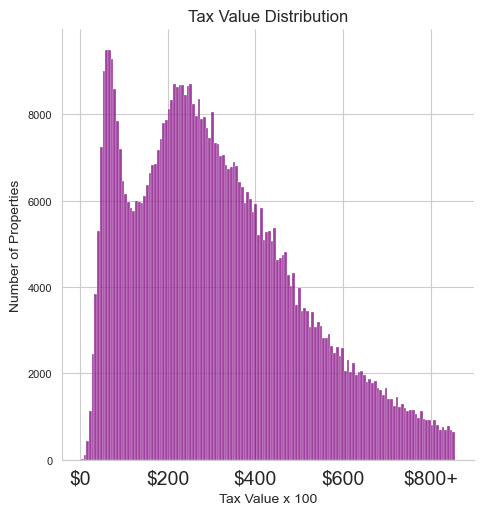

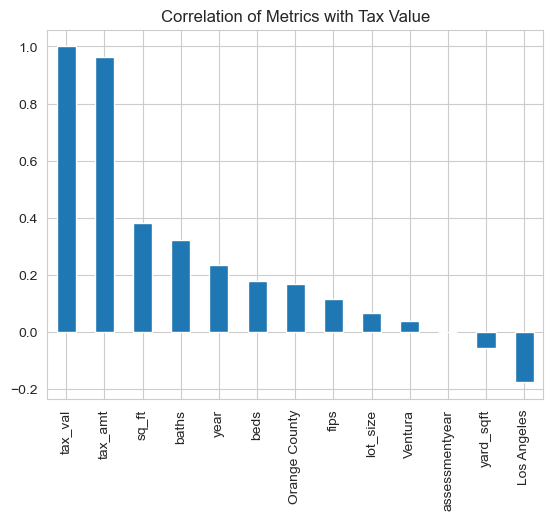

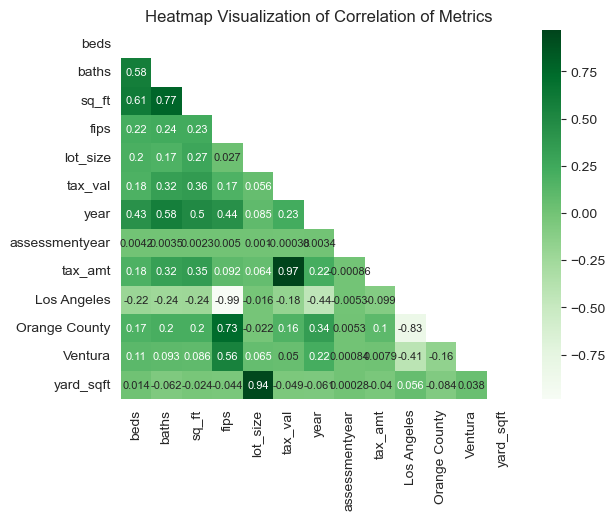

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,Los Angeles,Orange County,Ventura,yard_sqft
beds,1.000000,0.584833,0.610030,0.219384,0.198572,0.182136,0.433002,0.004226,0.180112,-0.219259,0.171863,0.107806,0.014149
baths,0.584833,1.000000,0.770304,0.235187,0.170862,0.323810,0.580874,0.003471,0.318800,-0.239377,0.202503,0.093362,-0.062207
sq_ft,0.610030,0.770304,1.000000,0.230425,0.274568,0.355577,0.495558,0.002341,0.348050,-0.235562,0.202764,0.086166,-0.023573
fips,0.219384,0.235187,0.230425,1.000000,0.026654,0.170461,0.440315,0.005021,0.092006,-0.986825,0.730148,0.556157,-0.044019
lot_size,0.198572,0.170862,0.274568,0.026654,1.000000,0.055882,0.084576,0.001036,0.063747,-0.016485,-0.022000,0.065253,0.941036
tax_val,0.182136,0.323810,0.355577,0.170461,0.055882,1.000000,0.225141,-0.000384,0.971070,-0.176981,0.161482,0.049776,-0.049427
year,0.433002,0.580874,0.495558,0.440315,0.084576,0.225141,1.000000,0.003417,0.219708,-0.439759,0.343648,0.217940,-0.060863
assessmentyear,0.004226,0.003471,0.002341,0.005021,0.001036,-0.000384,0.003417,1.000000,-0.000860,-0.005334,0.005269,0.000843,0.000281
tax_amt,0.180112,0.318800,0.348050,0.092006,0.063747,0.971070,0.219708,-0.000860,1.000000,-0.099209,0.102715,0.007946,-0.039981
Los Angeles,-0.219259,-0.239377,-0.235562,-0.986825,-0.016485,-0.176981,-0.439759,-0.005334,-0.099209,1.000000,-0.831077,-0.414370,0.055659


In [17]:
wr.show_corr(train)

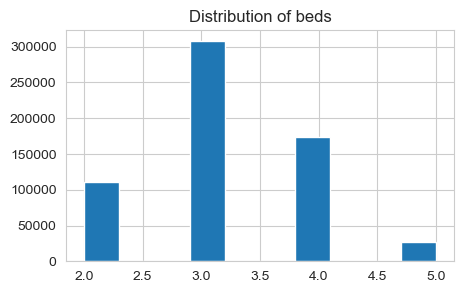

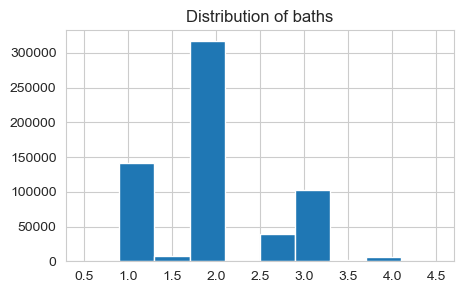

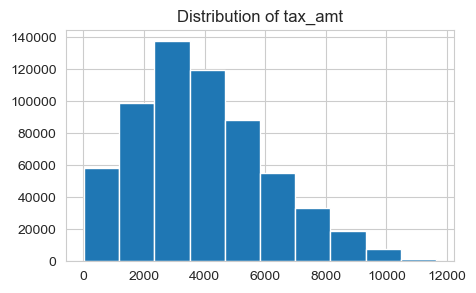

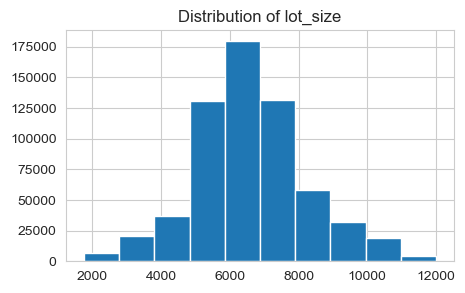

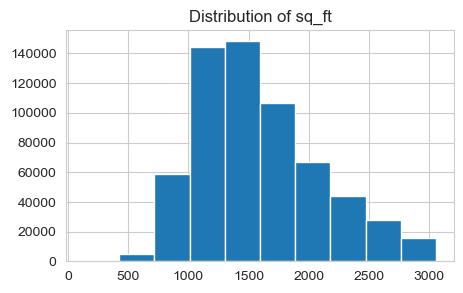

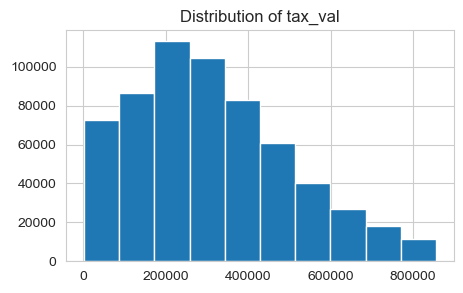

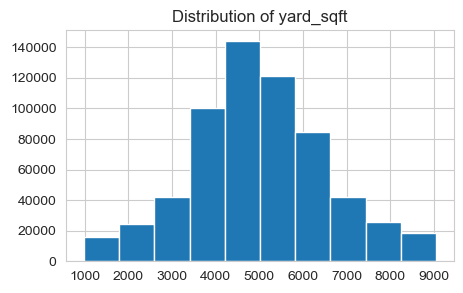

In [18]:
 for col in outliers:
    plt.figure(figsize= (5,3))
    train[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()

### Statistical Analysis

### **Q1: Do homes with more bathrooms have higher tax values?**

Null Hypothesis: Homes with more bathrooms will not have higher tax values than homes with less bathrooms

Hypothesis: Homes with more bathrooms will have higher tax values than homes with less values

In [19]:
# Finding my mode for bathroom counts to compare it to my mean. Looks like they're both 
# 2 baths. Now I can use that in my visuals
print(f' Mode of Bathrooms in dataset: {train.baths.mode()}')
print(f' Mean of Bathrooms in dataset: {round(train.baths.mean(), 2)}')
print(f' Median of Bathrooms in dataset: {train.baths.median()}')

 Mode of Bathrooms in dataset: 0    2.0
Name: baths, dtype: float64
 Mean of Bathrooms in dataset: 1.99
 Median of Bathrooms in dataset: 2.0


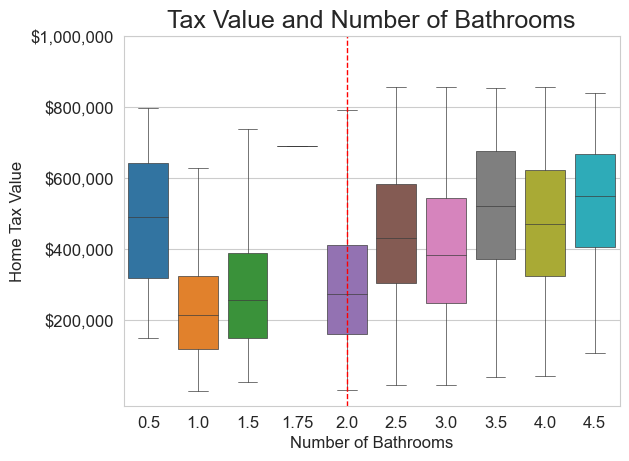

We reject the null hypothesis.
Average property value of properties with more than two full bathrooms $417,352
Average property value of properties with less than three full bathrooms $280,363


In [20]:
wr.q1_test(train)

### **Question 2: Does larger yard size increase tax value?**

**H^O:** Larger yard size decreases tax value.

**Hypothesis:** Larger yard size increases tax value.

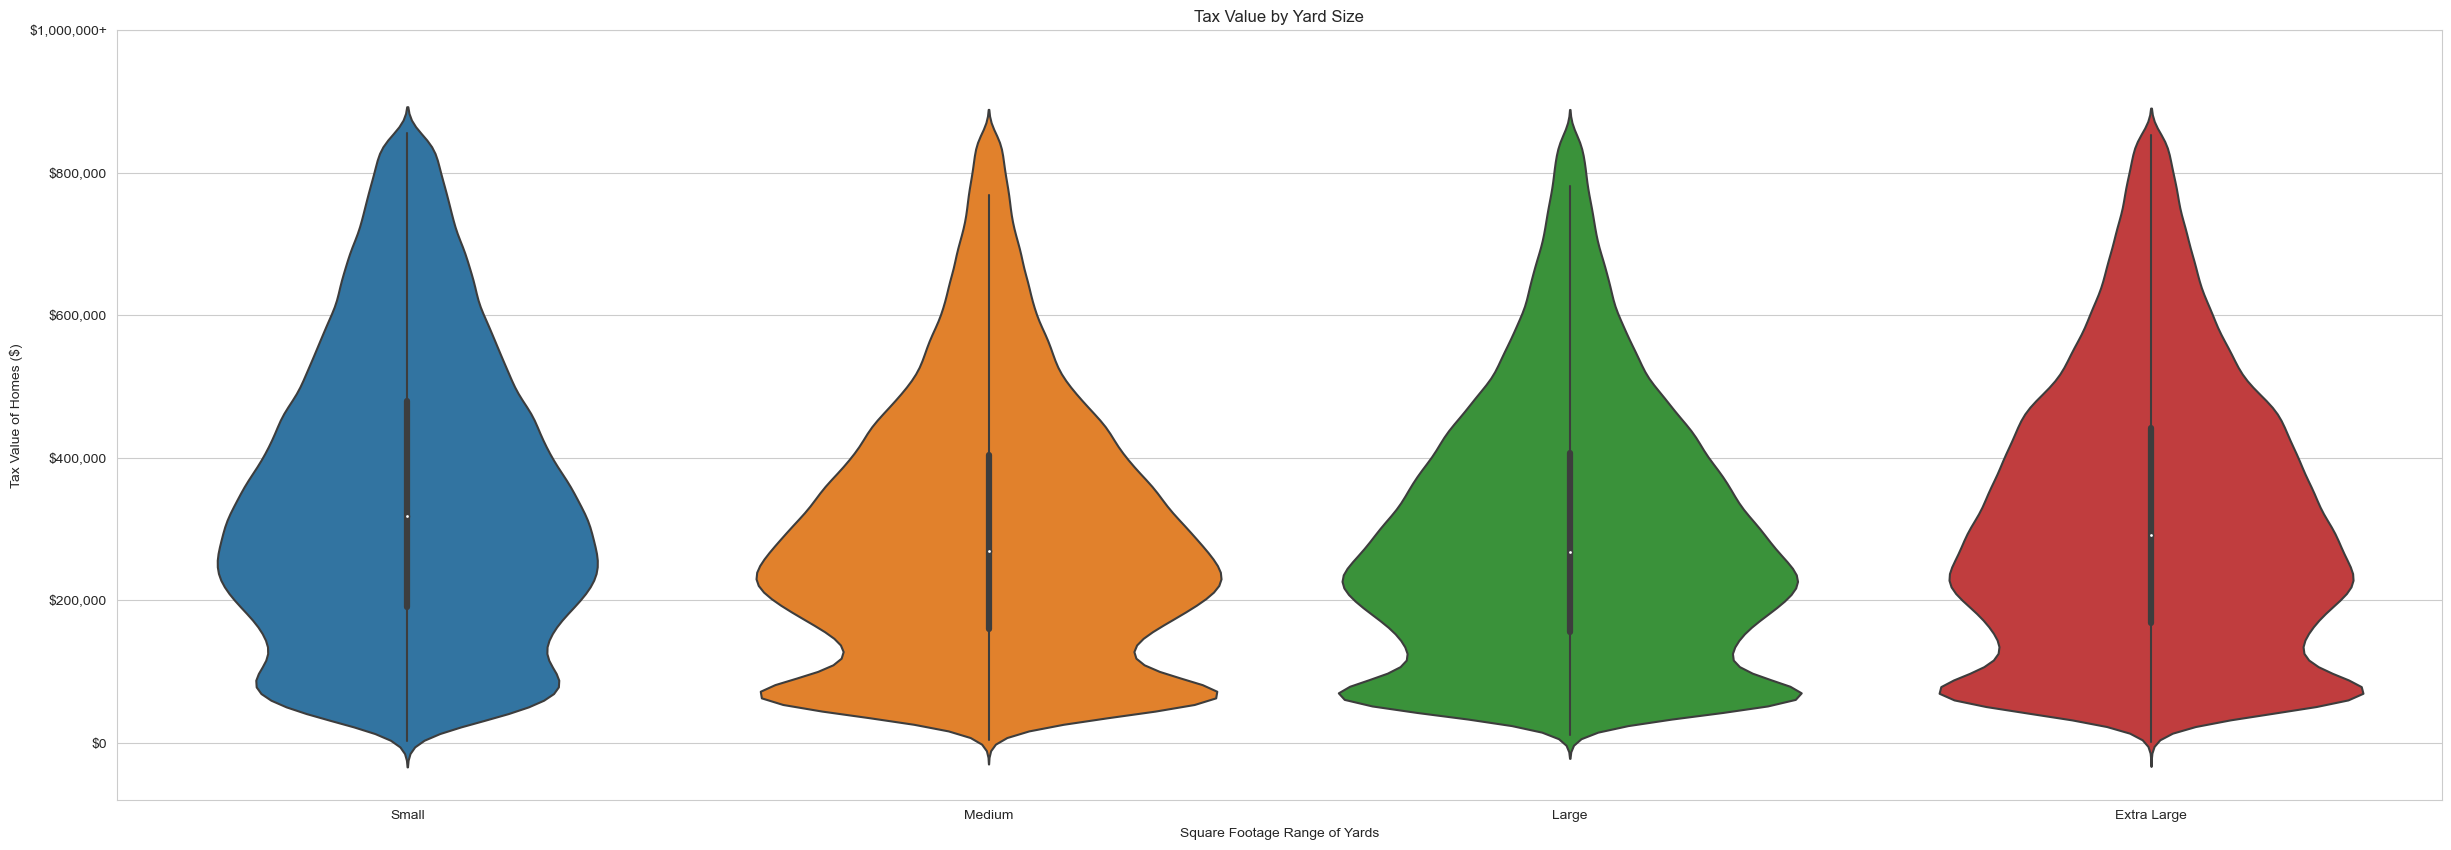

ANOVA results:
F-statistic: 2485.98
p-value: 0.0
We reject the null hypothesis


In [21]:
wr.q2_test(train)

### **Question 3: Does county location effect tax value?**

**H^O:** Tax value means will be equal across all three counties.

**Hypothesis:** Tax values will be very different across all three counties.

In [22]:
train.county.value_counts()

Los Angeles      420509
Orange County    151422
Ventura           46136
Name: county, dtype: int64

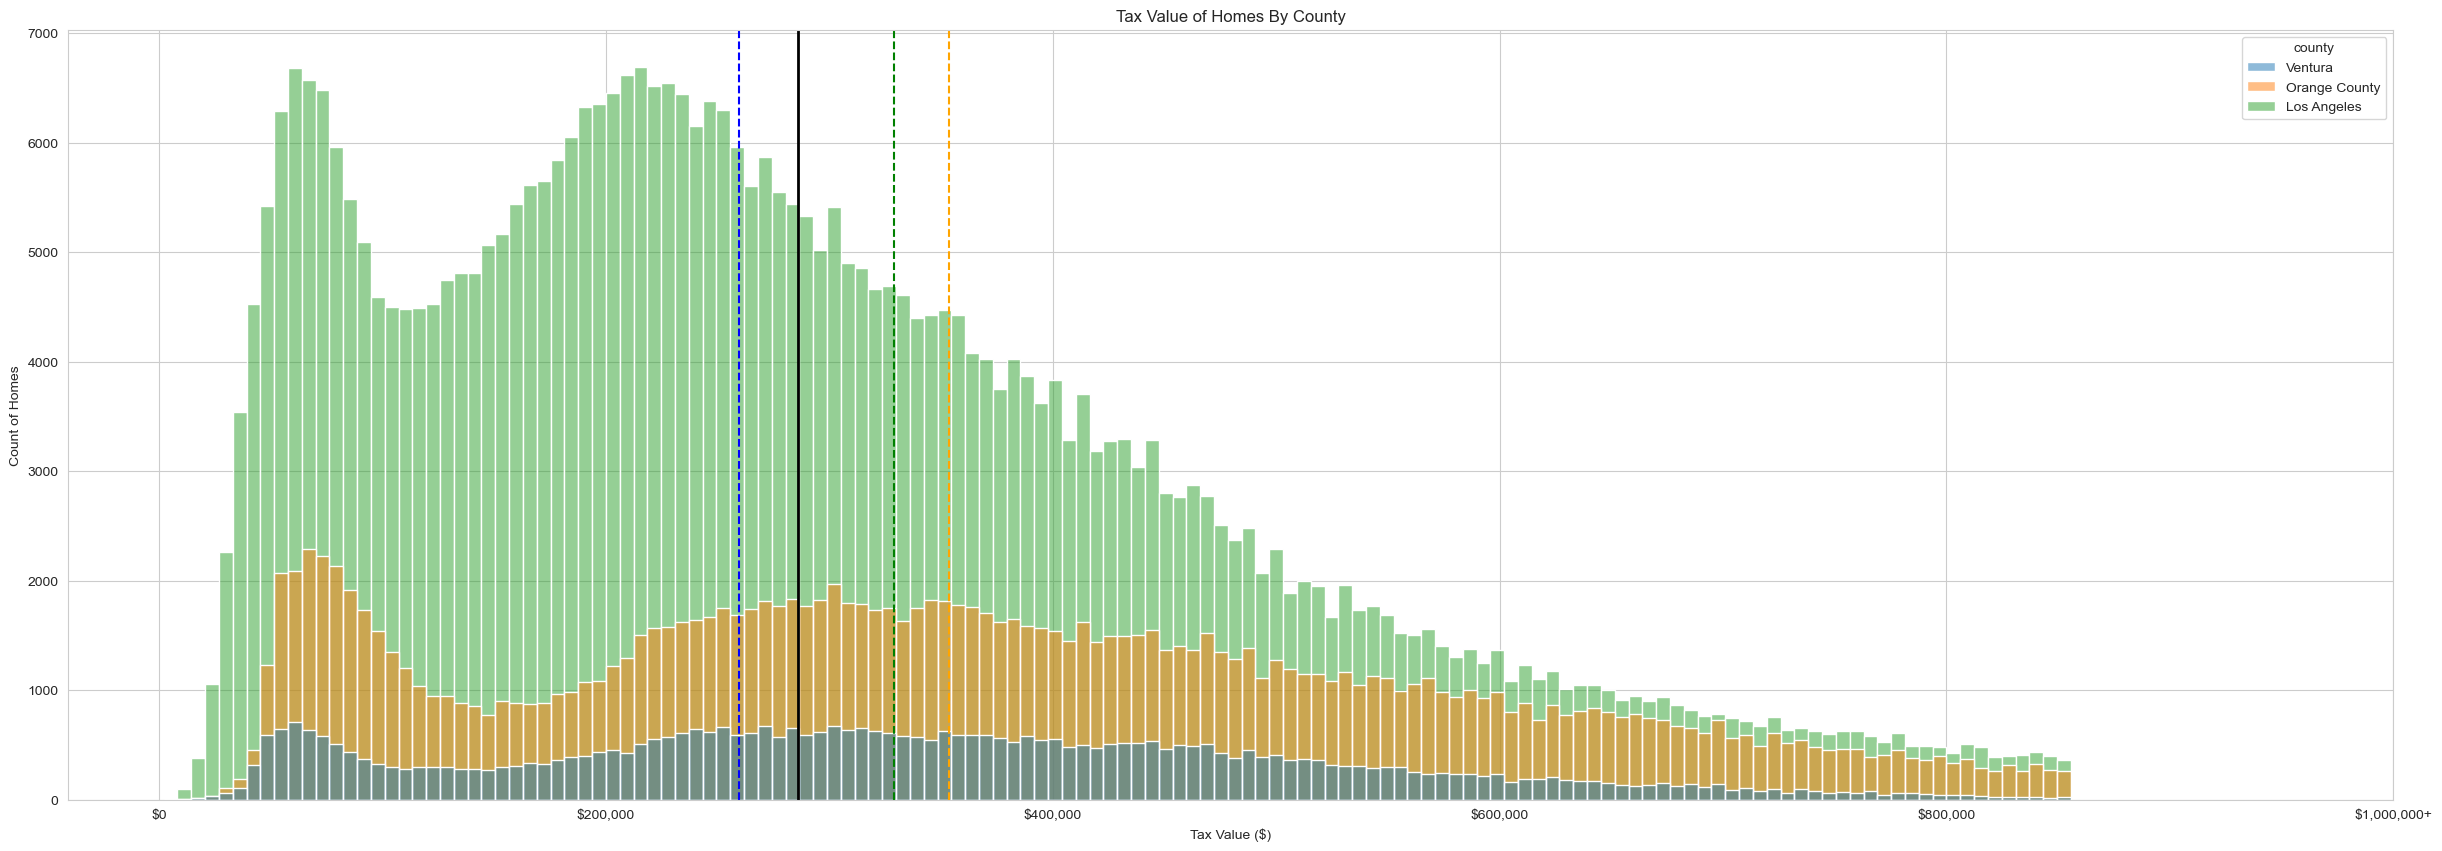

Median Tax Value for homes in LA County: $259738.0
Median Tax Value for homes in Orange County: $353433.5
Median Tax Value for homes in Ventura County: $329000.0
We can reject the null hypothesis


In [23]:
wr.q3_test(train)

**Observations**

- Homes in LA county have the lowest median tax values and the lowest average tax values compared to homes in Orange or Ventura counties
- The median tax value across all counties is $286,000
- Homes in Orange county have the highest median tax values

### **Q1: Do homes with more bathrooms have higher tax values?**

~~**H^O**: Homes with more bathrooms will not have higher tax values than homes with less bathrooms~~
**Hypothesis**: Homes with more bathrooms will have higher tax values than homes with less values

### **Question 2: Does larger yard size increase tax value?**

~~**H^O:** Larger yard size decreases tax value.~~

**Hypothesis:** Larger yard size increases tax value.


### **Question 3: Does county location effect tax value?**

~~**H^O:** Tax value means will be equal across all three counties.~~

**Hypothesis:** Tax values will be very different across all three counties.

## Scaling

In [24]:
toscale = ['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura', 'tax_val']

train_sc, val_sc, test_sc = wr.scaling(train, val, test, toscale)

In [25]:
train.head(2)

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft,yardcats
256228,3.0,2.0,1244.0,6059.0,6100.0,68944.0,1968.0,2016.0,1011.66,Orange County,0,1,0,4856.0,Medium
1313460,3.0,1.0,1824.0,6037.0,3530.0,345000.0,1923.0,2016.0,4287.94,Los Angeles,1,0,0,1706.0,Small


In [26]:
train_sc.head(2)

,beds,baths,sq_ft,fips,lot_size,tax_val,year,assessmentyear,tax_amt,county,Los Angeles,Orange County,Ventura,yard_sqft,yardcats
256228,0.333333,0.375,0.380171,6059.0,6100.0,0.078332,1968.0,2016.0,1011.66,Orange County,0.0,1.0,0.0,0.480283,Medium
1313460,0.333333,0.125,0.578462,6037.0,3530.0,0.401737,1923.0,2016.0,4287.94,Los Angeles,1.0,0.0,0.0,0.089658,Small


In [27]:
#Set targets and features for modeling
X_train = train_sc[['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']]
y_train = train["tax_val"]
X_test = test_sc[['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']]
y_test = test["tax_val"]
X_val = val_sc[['beds','baths','sq_ft','yard_sqft','Los Angeles','Orange County','Ventura']]
y_val = val["tax_val"]

In [28]:
type(y_val)

pandas.core.series.Series

In [29]:
#Make ys into dataframes
y_train=pd.DataFrame(y_train)
y_val=pd.DataFrame(y_val)
y_test=pd.DataFrame(y_test)

## Modeling

The goal of my modeling is to reduce RMSE for train and validate data. I'll calculate my RMSE for mean and median data, and I'll finish by comparing my models to that data. I'm only dropping my non-numeric features for modeling.

#### Features kept:
- beds
- baths
- tax_val
- sq_ft
- Los Angeles
- Orange County
- Ventura
- yard_sqft



In [30]:
#Establish Baseline using mean
baseline_mean= y_train.tax_val.mean()
baseline_median= y_train.tax_val.median()
y_train['baseline_mean'] = baseline_mean
y_train['baseline_median']= baseline_median
y_val['baseline_mean'] = baseline_mean
y_val['baseline_median']= baseline_median

# Calculate rmse for train, val
rmse_train=round(mean_squared_error(y_train.tax_val, y_train.baseline_mean, squared=False),2) 
rmse_val=round(mean_squared_error(y_val.tax_val, y_val.baseline_mean, squared=False), 2)
rmse_train_med=round(mean_squared_error(y_train.tax_val, y_train.baseline_median, squared=False), 2)
rmse_val_med=round(mean_squared_error(y_val.tax_val, y_val.baseline_median, squared=False), 2)

In [31]:
y_val.head(2)

,tax_val,baseline_mean,baseline_median
311978,239600.0,314018.878332,286000.0
1004974,75684.0,314018.878332,286000.0


In [32]:
# y_train.tax_val.mean()
print(f' RMSE Train Median: ${rmse_train_med}')
print(f' RMSE Validate Median: ${rmse_val_med}')
print(f' RMSE Train Mean: ${rmse_train}')
print(f' RMSE Train Mean: ${rmse_val}')

 RMSE Train Median: $190630.03
 RMSE Validate Median: $190283.44
 RMSE Train Mean: $188559.68
 RMSE Train Mean: $188282.18


#### Base Model Differences

In [33]:
# Checking for functionality
base_results = wr.comp_rmse_mm(y_train, y_val)

In [34]:
base_results

,model,Train RMSE,Validate RMSE,Difference
0,Baseline Mean,"$188,559.68","$188,282.18",277.492633
0,Baseline Median,"$190,630.03","$190,630.03",346.592445


#### Target Distribution

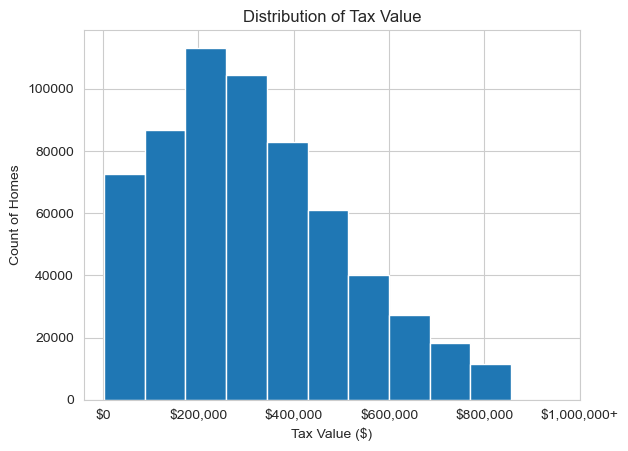

In [35]:
plt.hist(y_train.tax_val)
plt.title('Distribution of Tax Value')
plt.xticks(ticks= [0, 200000, 400000, 600000, 800000, 1_000_000], labels = ['$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000+'])
plt.xlabel('Tax Value ($)')
plt.ylabel('Count of Homes')
plt.show()

In [36]:
# Creating my modeling objects
lr = LinearRegression(normalize=True)
ll = LassoLars(alpha=1)
pf= PolynomialFeatures(degree= 5)

### MODEL 1: Polynomial Regression

In [37]:
# Fitting my model
X_train_pf = pf.fit_transform(X_train)
X_val_pf = pf.transform(X_val)

In [38]:
lr.fit(X_train_pf, y_train['tax_val'])
y_train['pf_pred'] = lr.predict(X_train_pf)
pf_rmse_train= round(mean_squared_error(y_train['tax_val'], y_train['pf_pred'], squared=False),2)

y_val['pf_pred'] = lr.predict(X_val_pf)
pf_rmse_val= round(mean_squared_error(y_val['tax_val'], y_val['pf_pred'], squared=False),2)
pfdifference = pf_rmse_train - pf_rmse_val

pf_r2_train= explained_variance_score(y_train.tax_val, y_train.pf_pred)
pf_r2_val = explained_variance_score(y_val.tax_val, y_val.pf_pred)

In [39]:
pfmetrics = pd.DataFrame(data = [{ 'model': 'PolyFeats',
                                   'Train RMSE': '${:,.2f}'.format(pf_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(pf_rmse_val),
                                   'Difference': pfdifference,
                                   'r2 Train': pf_r2_train,
                                   'r2 Validate': pf_r2_val}])



In [40]:
pfmetrics

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,PolyFeats,"$171,005.85","$170,752.87",252.98,0.177522,0.17754


### MODEL 2: OLS

In [41]:
# Fit the model to train data
lr.fit(X_train, y_train.tax_val)

# Predict train
y_train['pred_ols'] = lr.predict(X_train)
y_val['pred_ols'] = lr.predict(X_val)

# Evaluate RMSE
ols_rmse_train = round(mean_squared_error(y_train.tax_val, y_train.pred_ols, squared=False), 2) 
ols_rmse_val = round(mean_squared_error(y_val.tax_val, y_val.pred_ols, squared=False), 2) 
olsdifference = ols_rmse_train - ols_rmse_val

# Evaluate r2
ols_r2_train= explained_variance_score(y_train.tax_val, y_train.pred_ols)
ols_r2_val = explained_variance_score(y_val.tax_val, y_val.pred_ols)

In [42]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", ols_rmse_train, 
      "\nValidation/Out-of-Sample: ", ols_rmse_val)

RMSE for OLS using LinearRegression
Training/In-Sample:  172286.18 
Validation/Out-of-Sample:  171916.93


In [43]:
olsmetrics = pd.DataFrame(data = [{ 'model': 'OLS',
                                   'Train RMSE': '${:,.2f}'.format(ols_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(ols_rmse_val),
                                   'Difference': olsdifference,
                                   'r2 Train': ols_r2_train,
                                   'r2 Validate': ols_r2_val}])

In [44]:
olsmetrics

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,OLS,"$172,286.18","$171,916.93",369.25,0.16516,0.166287


### Model 3: LASSO LARS

In [45]:
#Fit the model to train data
ll.fit(X_train, y_train.tax_val)

# Predict train
y_train['pred_ll'] = ll.predict(X_train)
y_val['pred_ll'] = ll.predict(X_val)


# Evaluate RMSE
ll_rmse_train = round(mean_squared_error(y_train.tax_val, y_train.pred_ll, squared=False), 2) 
ll_rmse_val = round(mean_squared_error(y_val.tax_val, y_val.pred_ll, squared=False), 2) 
lldifference = ll_rmse_train - ll_rmse_val

# Evaluate r2
ll_r2_train= explained_variance_score(y_train.tax_val, y_train.pred_ll)
ll_r2_val = explained_variance_score(y_val.tax_val, y_val.pred_ll)

In [46]:
print("RMSE for LASSO LARS\nTraining/In-Sample: ", ll_rmse_train, 
      "\nValidation/Out-of-Sample: ", ll_rmse_val)

RMSE for LASSO LARS
Training/In-Sample:  172299.17 
Validation/Out-of-Sample:  171927.87


In [47]:
llmetrics = pd.DataFrame(data = [{ 'model': 'Lasso Lars',
                                   'Train RMSE': '${:,.2f}'.format(ll_rmse_train),
                             'Validate RMSE': '${:,.2f}'.format(ll_rmse_val),
                                   'Difference': lldifference,
                                   'r2 Train': ll_r2_train,
                                   'r2 Validate': ll_r2_val}])

In [48]:
llmetrics

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,Lasso Lars,"$172,299.17","$171,927.87",371.3,0.165034,0.166181


In [49]:
wr.comp_models(X_train, y_train, X_val, y_val)

,model,Train RMSE,Validate RMSE,Difference,r2 Train,r2 Validate
0,Baseline Mean,"$188,559.68","$188,282.18",277.492633,NaN,NaN
0,Baseline Median,"$190,630.03","$190,630.03",346.592445,NaN,NaN
0,Lasso Lars,"$172,299.17","$171,927.87",371.300000,0.165034,0.166181
0,OLS,"$172,286.18","$171,916.93",369.250000,0.165160,0.166287
0,PolyFeats,"$171,005.85","$170,752.87",252.980000,0.177522,0.177540


#### Notes

- My models are calculated on scaled data and they all measure against baseline mean
- All of my models outperform my baseline model and none of them appear to be overfit
- My best model is polynomial features with a degree of 5. It outperforms my baseline mean validate RMSE by $17,530, or 9%, and has r2 difference in the train and validate sets that are nearly identical


### CONCLUSION

- During exploration, I found that bathroom count was a really great indicator of predicting tax value within a home. Feature engineering the different yard sizes to predicts home tax value also provided valuable insights. However, the best indicator of tax value was property county location. When exploring this data in the future, I would start by separating the data by county and seeing how the features I chose shift in correlation across the counties individually.

#### Recommendations

As someone who has worked with residential property data before, I understand that there is a differnce in tax value and assessed property (or market) value. Tax value is calculated by the county where the property is located and is calculated by an assessor from that county. The assessor looks at comps (comperable properties) that have recently been sold, the value of recent structural improvements, and the cost of replacing the home (or the property it's on) if it were destroyed. Tax value usually represents 80% of market value. Market value also relies on comps, but also on appraisals, which are usually based on square footage. In the future, I would base this project around predicting market value.